# Stroke Prediction Dataset
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset  
La idea sería predecir si el paciente es propenso a tener ("likely to have") un ACV (stroke) en base a características como género, hipertención, IMC, fumador, **SI SE CASÓ ALGUNA VEZ (?)**, etc.

## Índice
1. [AED](#aed)
    * [Visualización DataFrame](#df)
    * [Correlation Matrix](#corr)
    * [Violinplots](#violin)
    * [Scatterplot](#pair)
    * [Feature processing](#feat)
        * [Exploración BMI](#bmi)
\
&nbsp;
2. [Model Fitting](#model)
    * [Scaling](#scale)
    * [LinearRegression (ya aprendimos que no tiene sentido)](#lr)
    * [PCA](#pca)
    * [tSNE](#tsne)
    * [Manifold Learning](#manifold)
    * [LogisticRegression](#log)
    * [RandomForest](#rf)

In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 400
# mpl.rcParams.update({'font.size': 6})

# Análisis Exploratorio de Datos <a class="anchor" id="aed"></a>

## Visualización DataFrame <a class="anchor" id="df">

In [50]:
#comparo el dataframe original con el dataframe solo de train
df = pd.read_csv("datasets/stroke/healthcare-dataset-stroke-data.csv")
df_train = pd.read_csv("datasets/stroke/healthcare-dataset-stroke-data_train.csv")
print(df.stroke.value_counts())
print(df_train.stroke.value_counts())

0    4861
1     249
Name: stroke, dtype: int64
0    3884
1     204
Name: stroke, dtype: int64


In [51]:
df = pd.read_csv("datasets/stroke/healthcare-dataset-stroke-data_train.csv")
df[df["age"]>=30].stroke.value_counts()


0    2675
1     203
Name: stroke, dtype: int64

In [52]:
df.drop("id", axis=1, inplace=True)

In [53]:
# Balance del dataset
cant_strokes = df.stroke.sum()
print(f"La proporción de datos con stroke positivo es del {cant_strokes/df.shape[0]*100:.1f} %")

La proporción de datos con stroke positivo es del 5.0 %


In [54]:
# Buscamos NaNs
df.isna().sum()

Unnamed: 0             0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  157
smoking_status         0
stroke                 0
dtype: int64

---
No sabemos si conviene eliminar los pacientes con NaNs en BMI o reemplazar por el mean o algo así  
No quisiéramos perder casos con stroke positivo ya que no tenemos muchos

In [55]:
df_clean = df.dropna()
print(f"{'strokes en df':20} {df.stroke.sum()}")
print(f"{'strokes en df_clean':20} {df_clean.stroke.sum()}")

strokes en df        204
strokes en df_clean  175


Por ahora llenamos con la mediana

In [56]:
bmi_median = df.bmi.median()  # 28.1
df.bmi.fillna(bmi_median, inplace=True)

In [57]:
df.columns

Index(['Unnamed: 0', 'gender', 'age', 'hypertension', 'heart_disease',
       'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level',
       'bmi', 'smoking_status', 'stroke'],
      dtype='object')

In [58]:
# Tenemos 3 variables numéricas
num_cols = ["age", "avg_glucose_level", "bmi"]  # El BMI es el IMC
num_df = df[num_cols]
# El resto son categóricas, algunas binarias y otras con varias opciones
cat_df = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
             'work_type', 'Residence_type', 'smoking_status', 'stroke']]

## Correlation Matrix <a class="anchor" id="corr">

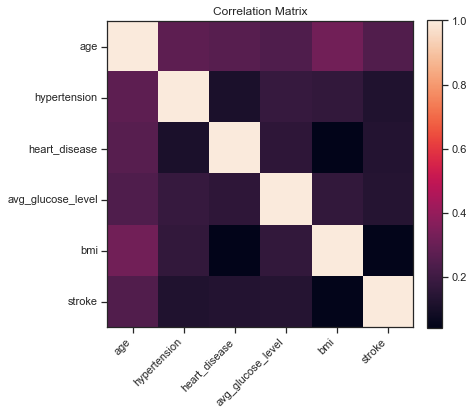

In [59]:
corr_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi','stroke']
plt.figure(figsize=(6, 6))
plt.imshow(df[corr_cols].corr())
plt.colorbar(fraction=0.0459, pad=0.04)  # Magia que encontré online para que la colorbar quede alineada
plt.title("Correlation Matrix")#, fontsize=6)
plt.xticks(np.arange(6), corr_cols, rotation=45, ha='right', va='top')#, fontsize=6)
plt.yticks(np.arange(6), corr_cols, rotation=0, ha='right', va='center')#, fontsize=6)
plt.show()

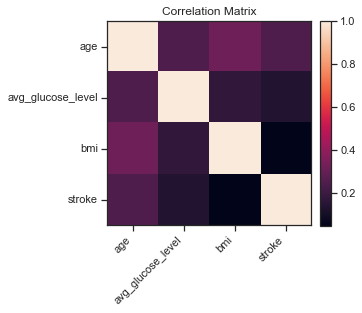

In [60]:
# Dejo las columnas numéricas, que tiene más sentido tiene dejar (creo)
plt.figure(figsize=(4, 4))
num_df2 = df[["age", "avg_glucose_level", "bmi","stroke"]]
plt.imshow(num_df2.corr())
plt.colorbar(fraction=0.0459, pad=0.04)  # Magia que encontré online para que la colorbar quede alineada
plt.title("Correlation Matrix")
plt.xticks(np.arange(4), num_df2.columns, rotation=45, ha='right', va='top')
plt.yticks(np.arange(4), num_df2.columns, rotation=0, ha='right', va='center')
plt.show()

## Violin plots <a class="anchor" id="violin">

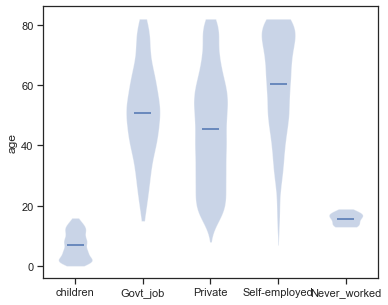

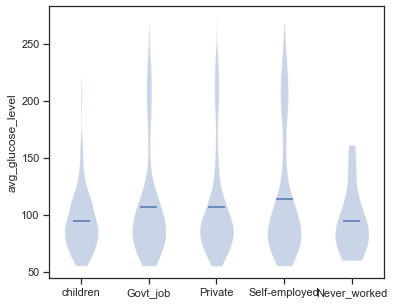

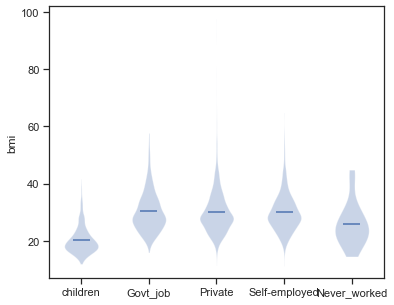

In [61]:
def violinplot(variable):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)

    #categories = df["stroke"].unique()  # 0 y 1
    categories = df["work_type"].unique()
    datos = [num_df.loc[(df["work_type"] == cat)][variable] for cat in categories]

    ax.violinplot(dataset=datos, showextrema=False, showmeans=True, points=1000)
    ax.xaxis.set_ticks(range(1, len(categories) + 1))
    #ax.xaxis.set_ticklabels(["stroke", "no stroke"])
    ax.xaxis.set_ticklabels(df["work_type"].unique())
    ax.set_ylabel(variable)#, fontsize=6)
    #plt.title(f"{variable} vs stroke")


for var in num_df.columns:
    violinplot(var)
plt.show()

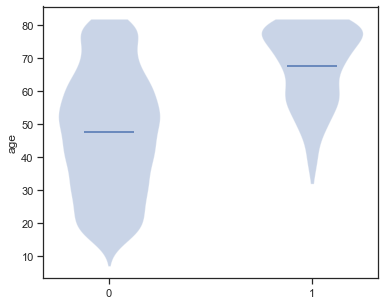

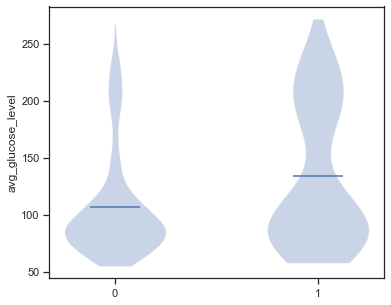

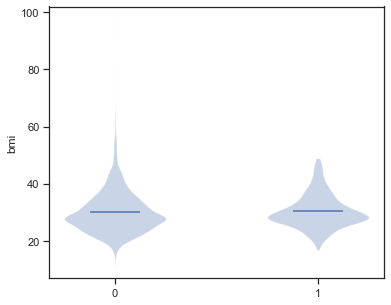

In [62]:
#acá armé un violinplot que usa los datos que no tienen work_type=children
index_names = df[ df['work_type'] == "children" ].index
dfadulto = df.drop(index_names)
def violinplot2(variable):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)

    #categories = df["stroke"].unique()  # 0 y 1
    categories = df["stroke"].unique()
    datos = [dfadulto.loc[(df["stroke"] == cat)][variable] for cat in categories]

    ax.violinplot(dataset=datos, showextrema=False, showmeans=True, points=1000)
    ax.xaxis.set_ticks(range(1, len(categories) + 1))
    #ax.xaxis.set_ticklabels(["stroke", "no stroke"])
    ax.xaxis.set_ticklabels(df["stroke"].unique())
    ax.set_ylabel(variable)#, fontsize=6)
    #plt.title(f"{variable} vs stroke")


for var in num_df.columns:
    violinplot2(var)

## Scatter plot (pair plot) <a class="anchor" id="pair">

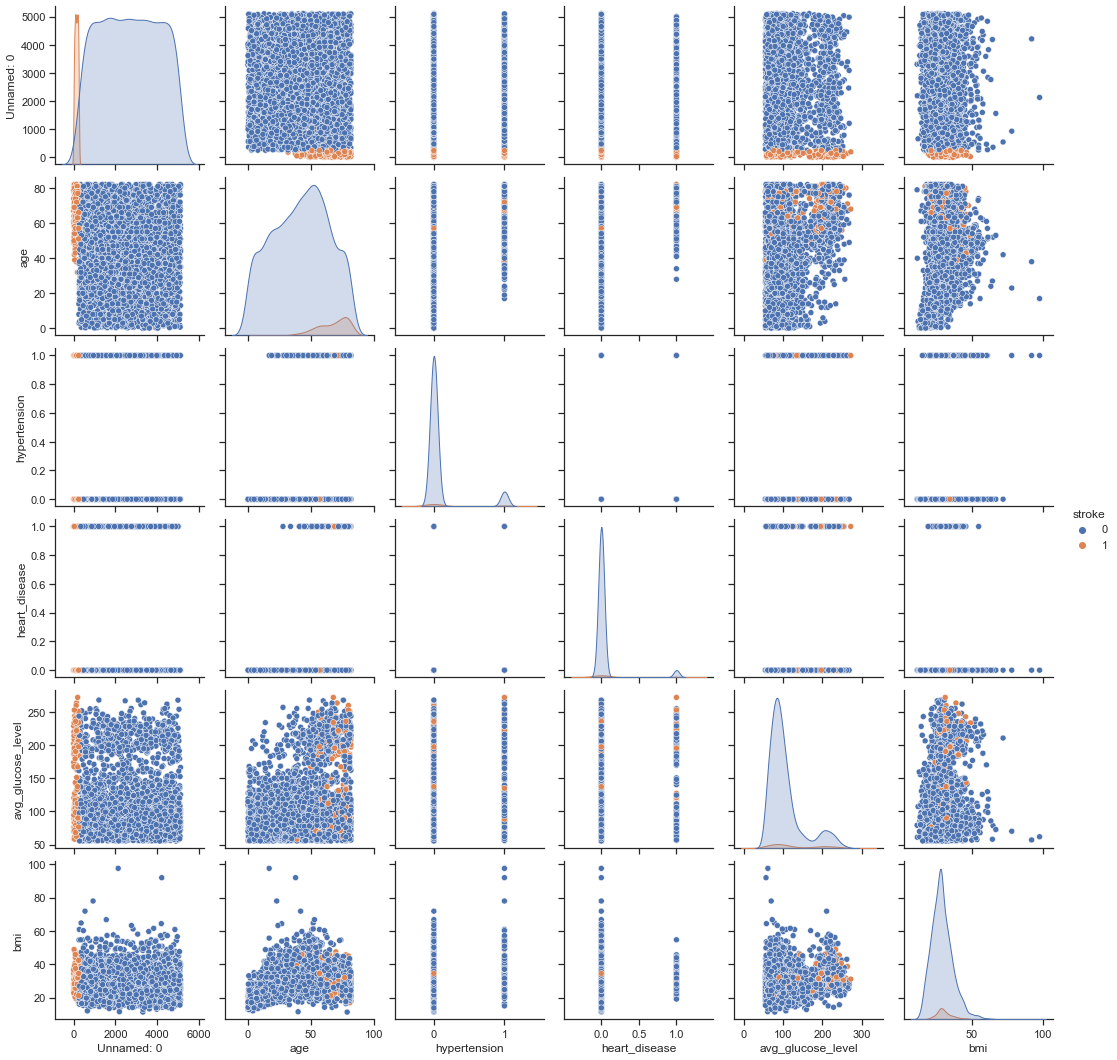

In [63]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="stroke")
plt.show()

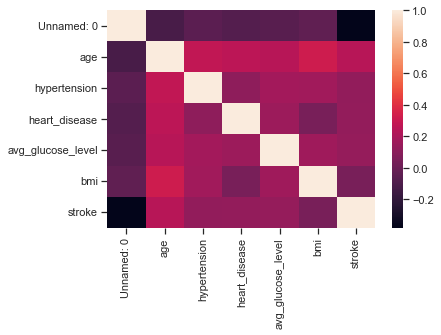

In [64]:
sns.heatmap(df.corr())
plt.show()

Otro problema son los Unknown en smoking_status

In [65]:
idx = df[(df["smoking_status"] == "Unknown")].index

In [66]:
df.drop(idx).stroke.value_counts()

0    2686
1     170
Name: stroke, dtype: int64

## Feature processing <a class="anchor" id="feat">

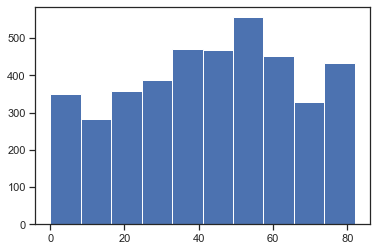

In [67]:
plt.hist(df.age)
plt.show()

In [68]:
smokers = {
    "never smoked": 0,
    "Unknown": 1,
    "formerly smoked": 2,
    "smokes": 3,
}

df["smoking_num"] = [smokers[cat] for cat in df.smoking_status]

In [69]:
df.work_type.unique()
# Orden de estrés: children --> Never_worked --> Private+Govt_job --> Self-employed => StdScaler
# Sino, usar un OneHotEncoder

array(['children', 'Govt_job', 'Private', 'Self-employed', 'Never_worked'],
      dtype=object)

In [70]:
work_types = {
    'Private': 2,
    'Self-employed': 3,
    'Govt_job': 2,
    'children': 0,
    'Never_worked': 1,
}

df["work_type_num"] = [work_types[cat] for cat in df.work_type]

In [71]:
df.Residence_type.unique()

array(['Urban', 'Rural'], dtype=object)

In [72]:
df.ever_married.unique()

array(['No', 'Yes'], dtype=object)

In [73]:
df["Residence_type_num"] = [0 if cat == "Rural" else 1 for cat in df.Residence_type]

In [74]:
df["gender_num"] = [0 if cat == "Male" else 1 for cat in df.gender]

In [75]:
df["ever_married_num"] = [0 if cat == "No" else 1 for cat in df.ever_married]

### Exploración BMI <a class="anchor" id="bmi">

Veamos como varía con la edad

In [76]:
edades = [10, 20, 30, 40, 50, 60, 70, 100]
for i, edad in enumerate(edades):
    if i == 0:
        print(f"Hasta: {edad:3} años - BMI: {df.bmi[(df.age<edad)&(df.age>0)].median():.2f}")
    else:
        print(f"Hasta: {edad:3} años - BMI: {df.bmi[(df.age<edad)&(df.age>edades[i-1])].median():.2f}")

Hasta:  10 años - BMI: 18.40
Hasta:  20 años - BMI: 23.70
Hasta:  30 años - BMI: 26.80
Hasta:  40 años - BMI: 29.10
Hasta:  50 años - BMI: 29.90
Hasta:  60 años - BMI: 30.70
Hasta:  70 años - BMI: 29.70
Hasta: 100 años - BMI: 28.10


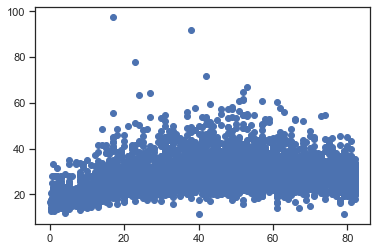

In [77]:
plt.scatter(df.age, df.bmi)
plt.show()

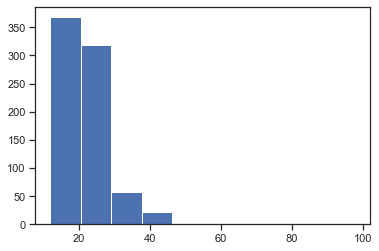

22.298051948051935


In [78]:
filtro_edad = df.age<20
plt.hist(df.bmi[filtro_edad])
plt.show()
print(df.bmi[filtro_edad].mean())

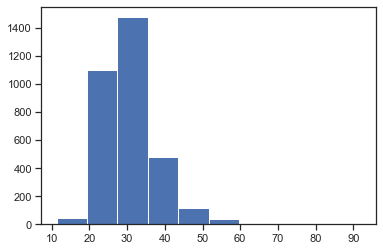

30.515742725880603


In [79]:
filtro_edad = df.age>20
plt.hist(df.bmi[filtro_edad])
plt.show()
print(df.bmi[filtro_edad].mean())

Ahora según género

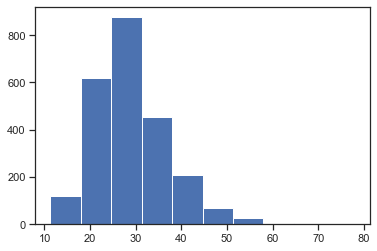

29.086518269634613


In [80]:
plt.hist(df.bmi[df.gender=="Female"])
plt.show()
print(df.bmi[df.gender=="Female"].mean())

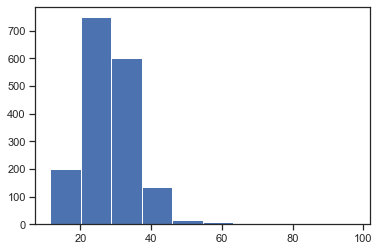

28.66918570591677


In [81]:
plt.hist(df.bmi[df.gender=="Male"])
plt.show()
print(df.bmi[df.gender=="Male"].mean())

Vemos que eventualmente seguro convendrá rellenar los NaNs de BMI teniendo en cuenta la edad en lugar de asignar la mediana de la columna entera.  
El nuevo dataframe quedó así:

In [82]:
df

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_num,work_type_num,Residence_type_num,gender_num,ever_married_num
0,1390,Male,13.0,0,0,No,children,Urban,65.51,25.9,Unknown,0,1,0,1,0,0
1,2650,Male,67.0,0,0,Yes,Govt_job,Rural,59.00,29.5,Unknown,0,1,2,0,0,1
2,2695,Female,50.0,0,0,Yes,Private,Urban,65.98,21.7,never smoked,0,0,2,1,1,1
3,3663,Female,74.0,0,0,Yes,Self-employed,Rural,72.54,28.4,never smoked,0,0,3,0,1,1
4,2621,Female,60.0,0,0,Yes,Private,Rural,83.16,29.7,smokes,0,3,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,1866,Male,10.0,0,0,No,children,Rural,99.87,28.1,formerly smoked,0,2,0,0,0,0
4084,2557,Male,27.0,0,0,Yes,Private,Urban,150.10,25.3,never smoked,0,0,2,1,0,1
4085,870,Male,49.0,0,0,Yes,Private,Rural,102.47,29.3,formerly smoked,0,2,2,0,0,1
4086,4650,Male,54.0,0,0,Yes,Private,Rural,100.47,50.2,formerly smoked,0,2,2,0,0,1


# Model Fitting <a class="anchor" id="model">

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [84]:
df.columns

Index(['Unnamed: 0', 'gender', 'age', 'hypertension', 'heart_disease',
       'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level',
       'bmi', 'smoking_status', 'stroke', 'smoking_num', 'work_type_num',
       'Residence_type_num', 'gender_num', 'ever_married_num'],
      dtype='object')

In [85]:
cols =[
    'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
    'bmi', 'stroke', 'smoking_num', 'Residence_type_num',
    'gender_num', 'ever_married_num', 'work_type_num'
]
df_ml = df[cols]
train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)

In [86]:
x_train = train_df.drop(["stroke"], axis=1)
t_train = train_df["stroke"]
x_test = test_df.drop(["stroke"], axis=1)
t_test = test_df["stroke"]

### Scaling <a class="anchor" id="scale">

In [131]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [88]:
pd.DataFrame(x_train_scaled)[8].value_counts()

 0.723226    2147
-1.382694    1123
Name: 8, dtype: int64

## Linear Regression <a class="anchor" id="lr">

In [89]:
# No tiene sentido hacer una regresión lineal pero la hicimos jeje, abajo hacemos regresión logística
modelo = Pipeline([
    ("poly", PolynomialFeatures()),
    ("reg", LinearRegression(fit_intercept=False))
])

from sklearn.model_selection import GridSearchCV

hyperparameters = {'poly__degree': np.arange(1, 3)}
grilla = GridSearchCV(modelo, hyperparameters, refit=True, cv=6, verbose=2, n_jobs=-1)
grilla.fit(x_train_scaled, t_train)

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.8s finished


GridSearchCV(cv=6, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'poly__degree': array([1, 2])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [90]:
GridSearchCV?

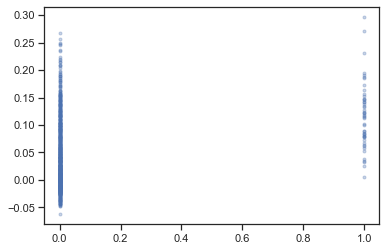

In [91]:
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

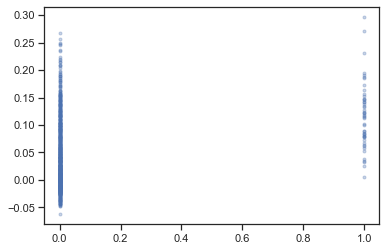

In [92]:
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

In [93]:
print(grilla.best_params_)

{'poly__degree': 1}


Aumentamos cantidad de folds

In [94]:
modelo = Pipeline([
    ("poly", PolynomialFeatures()),
    ("reg", LinearRegression(fit_intercept=False))
])

from sklearn.model_selection import GridSearchCV

hyperparameters = {'poly__degree': np.arange(1, 3)}
grilla = GridSearchCV(modelo, hyperparameters, refit=True, cv=30, verbose=3, n_jobs=-1)
grilla.fit(x_train_scaled, t_train)

Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


GridSearchCV(cv=30, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'poly__degree': array([1, 2])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

{'poly__degree': 1}


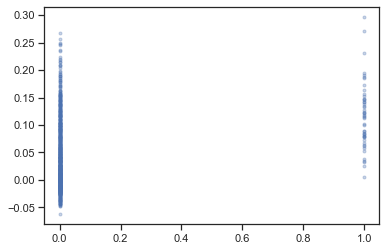

In [95]:
print(grilla.best_params_)
elmejor = grilla.best_estimator_
plt.plot(t_test, elmejor.predict(x_test_scaled), ".", alpha=0.3)
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error as mse
def rmse(x, t):
    return np.sqrt(mse(x, t))

In [97]:
ypred_train = elmejor.predict(x_train_scaled)
ypred_test = elmejor.predict(x_test_scaled)

In [98]:
print(f"RMSE train: {rmse(t_train, ypred_train):.3f}\nRMSE test:  {rmse(t_test, ypred_test):.3f}")

RMSE train: 0.203
RMSE test:  0.229


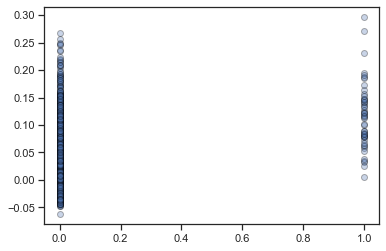

In [99]:
# plt.scatter(t_train, ypred_train)
plt.scatter(t_test, ypred_test, alpha=0.3, edgecolors="black")
plt.show()

## PCA <a class="anchor" id="pca">

In [100]:
#busco estudiar el PCA en 2 y 3 dimensiones para ver si se separan las categorías stroke y no stroke
df_ml
cols2 =[#saco stroke
    'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
    'bmi', 'smoking_num', 'Residence_type_num',
    'gender_num', 'ever_married_num', 'work_type_num'
]
""" 1ra:
    1.53718110e-01,  1.24913433e-03,  8.82976576e-04, 9.87569535e-01,  
    3.25667751e-02,  7.24965865e-04, -4.11213693e-05, 
    -5.50971860e-04,  2.13186576e-03, 2.97402766e-03]
    2da:
    [ -9.81054854e-01, -3.11656691e-03, -2.23625947e-03, 1.56459568e-01, 
    -1.10423893e-01, -3.62905555e-03, -3.64969039e-04, 
    -1.05255387e-03, -1.41453184e-02, -2.50823714e-02]"""
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #instanceo pca 2D
df_train = df_ml[cols2] #nuevo data set sin stroke
X_pca = pca.fit_transform(df_train) #aplico pca sobre el nuevo data set

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pablo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


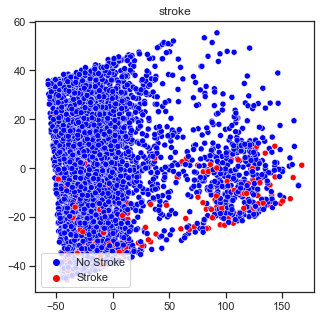

In [101]:
%matplotlib qt
#uso seaborn
df_ml["label"] = ["No Stroke" if cat == 0 else "Stroke" for cat in df_ml.stroke]#creo una nueva columna para poder setear el label en el scatter
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.scatterplot(*X_pca.T, hue=df_ml["label"] ,legend='full',
                     palette = {"No Stroke":"blue", "Stroke":"red"})#ploteo, con palette defino un color para cada elemento de los labels
ax.legend(loc='lower left')
etiqueta = "stroke"
#scat = ax.scatter(*X_pca.T, c=df_ml[etiqueta]/2, alpha=0.7, cmap=plt.cm.Set1)
plt.title(etiqueta)
f = lambda x: 2*x
#cb = plt.colorbar()
#plt.legend(*scat.legend_elements(func=f), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [102]:
pca.explained_variance_ratio_ #que porcentaje de la varianza hay en cada componente
np.diag(np.cov(df_train.T))

array([5.06974954e+02, 8.92773349e-02, 5.00580093e-02, 2.07948882e+03,
       5.95826905e+01, 1.15512930e+00, 2.50020709e-01, 2.43263747e-01,
       2.24851110e-01, 6.82440673e-01])

In [103]:
pca.components_ #como es cada componente

array([[ 1.52876614e-01,  1.28707274e-03,  8.45637172e-04,
         9.87688489e-01,  3.29204478e-02,  6.89821710e-04,
        -2.65922681e-05, -5.19703740e-04,  2.08797174e-03,
         2.99251876e-03],
       [-9.81277192e-01, -3.12463885e-03, -2.19275833e-03,
         1.55650873e-01, -1.09590491e-01, -3.52276690e-03,
        -1.76470110e-04, -9.93012754e-04, -1.42945629e-02,
        -2.50093873e-02]])

In [104]:
#invierto y calculo la diferencia al reducir la dimensionalidad
X_inv = pca.inverse_transform(X_pca)
print(np.allclose(X_inv, df_train))

np.mean(np.sum(np.square(X_inv - df_train), axis=1))

False


54.52029499738423

In [105]:
#hago el PCA 3D
from mpl_toolkits.mplot3d import Axes3D
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(df_train)

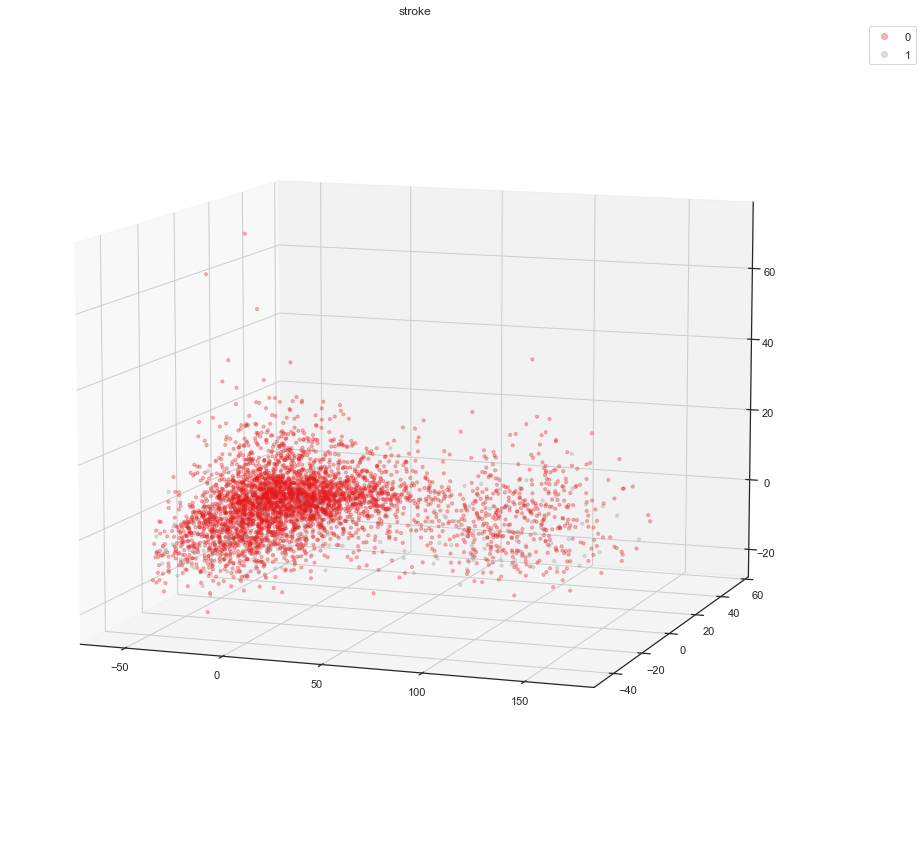

In [106]:
#grafico el PCA 3D
fig = plt.figure(figsize=(15,15))

etiqueta = "stroke"
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=df_ml[etiqueta], alpha=0.3, cmap=plt.cm.Set1, s=10)
ax.view_init(10, -70)
plt.title(etiqueta)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2) #seteo las legends, 0 = "No Stroke", 1 = "Stroke"
plt.show()

In [107]:
#me fijo que tan buenas son estas reducciones. Si tuviera todas las componentes cumsum = 1
cumsum = np.cumsum(pca.explained_variance_ratio_) #this tells us how much information is retained if we stop at each dimension
cumsum3 = np.cumsum(pca3.explained_variance_ratio_)
print(f"2 Componentes: {cumsum[1]}\n 3 Componentes: {cumsum3[2]}")

2 Componentes: 0.9794114922533339
 3 Componentes: 0.9991569604623568


## tSNE <a class="anchor" id="tsne">

In [108]:
from sklearn.manifold import TSNE
#pruebo tSNE a ver si separa los labels 
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(df_train)

/home/pablo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


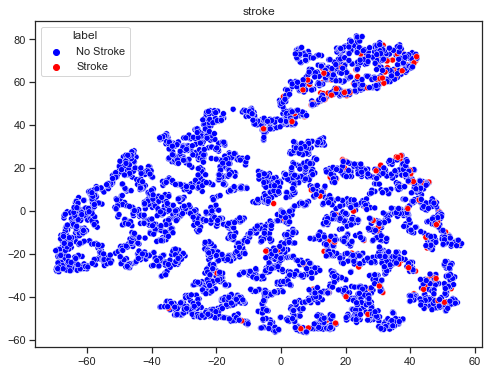

In [109]:
#lo grafico
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax = sns.scatterplot(*X_reduced_tsne.T, hue=df_ml["label"] ,legend='full',
                     palette = {"No Stroke":"blue", "Stroke":"red"})
#scat = ax.scatter(*X_reduced_tsne.T, c=df_ml[etiqueta], s=50, cmap=plt.cm.Set1, 
                  #edgecolors='None', alpha=0.3)
plt.title(etiqueta)
#plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [110]:
#Ahora pruebo tSNE 3D
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(df_train)#fit a subset to reduce computing time

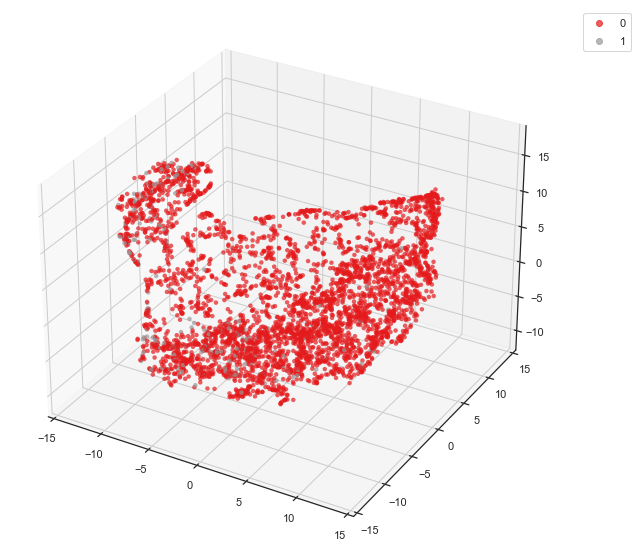

In [111]:
#lo grafico
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
etiqueta = "stroke"
scat = ax.scatter(*X_reduced_tsne_3d.T, c=df_ml[etiqueta], s=20, cmap=plt.cm.Set1, 
                  edgecolors='None', alpha=0.7)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

## Manifold Learning <a class="anchor" id="manifold">

In [112]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=3, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(df_train)

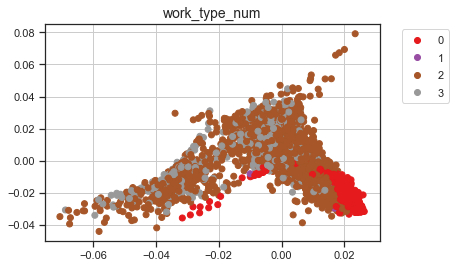

In [113]:
etiqueta = "work_type_num"
plt.title(etiqueta, fontsize=14)
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_ml[etiqueta], cmap=plt.cm.Set1)

# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

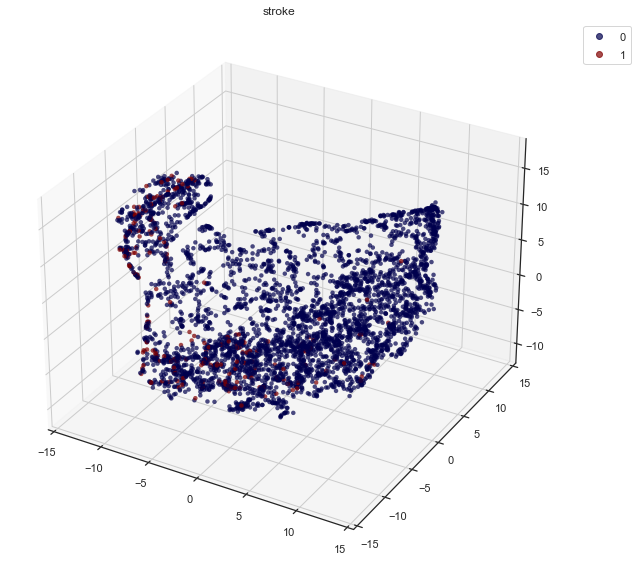

In [114]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=df_ml["stroke"], s=20, cmap=plt.cm.seismic, 
                  edgecolors='None', alpha=0.7)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.legend(*scat.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("stroke")
plt.show()


## Logistic Regression <a class="anchor" id="log">

In [115]:
# Pruebo Logistig Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
logistic_model = LogisticRegression()
logistic_model.fit(x_train_scaled, t_train)
ypred_log = cross_val_predict(logistic_model, x_train_scaled, t_train)
y_score_log = cross_val_predict(logistic_model, x_train_scaled, t_train, method="predict_proba")

array([-2.27038148, -2.25779967, -2.24440235, ...,  5.60129547,
        6.39365899,  8.93961392])

In [137]:
%matplotlib qt
from sklearn.metrics import roc_curve, precision_recall_curve
precision_log, recall_log, threshold_log_pr = precision_recall_curve(t_train, y_score_log[:,1])
fpr_log, tpr_log, threshold_log_roc = roc_curve(t_train, y_score_log[:,1])
plt.plot(precision_log, recall_log, ".")
plt.xlabel("Precisión")
plt.ylabel("Exhaustividad")
plt.figure()
plt.plot(fpr_log, tpr_log)
plt.xlabel("Tasa falsos positivos")
plt.ylabel("Tasa verdaderos positivos")

Text(0, 0.5, 'Tasa verdaderos positivos')

In [43]:
print(f"RMSE LogisticRegression model: {rmse(ypred_log, t_test):.3f}")

NameError: name 'rmse' is not defined

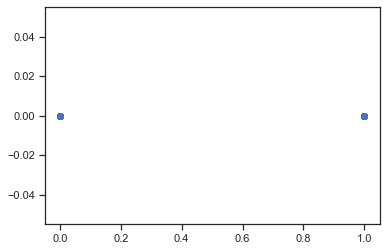

In [44]:
plt.scatter(t_test, ypred_log)
plt.show()

In [ ]:
(t_test == ypred_log).value_counts()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(t_test, ypred_log))

In [ ]:
df_log = pd.DataFrame({"t_test": t_test, "t_pred": ypred_log})

In [ ]:
# Me fijo si atinó prediciendo un 1
df_log[df_log["t_test"]==1]["t_pred"].sum()

In [ ]:
# Me fijo si predijo algún 1, mal o bien
df_log[df_log["t_pred"]==1]

In [ ]:
roc_auc_score(t_test, ypred_log)

# ‘roc_auc_score’ of 0.5 means the model is unable to distinguish between classes. Values close to 1.0 correspond to a strong separation between classes. The ‘f1_score’ is the harmonic mean of precision and recall. Similar to ‘roc_auc_score’, a perfect ‘f1_score’ is equal to 1.0:

## Random Forest <a class="anchor" id="rf">

In [ ]:
from sklearn.ensemble import RandomForestClassifier
reg_rf = RandomForestClassifier()
reg_rf.fit(x_train_scaled, t_train)

In [ ]:
ypred_rf = reg_rf.predict(x_test_scaled)
print(classification_report(t_test, ypred_rf))

In [ ]:
print("roc_auc_score: ", roc_auc_score(t_test, ypred_rf))

In [ ]:
df_rf = pd.DataFrame({"t_test": t_test, "t_pred": ypred_rf})

In [ ]:
df_rf[df_rf["t_pred"]==1]

In [ ]:
print(f"RMSE Random Forest: {rmse(t_test, ypred_rf):.3f}")